Oleg Litvinov: this was my first kaggle competition and the only thing I was able to do at that level of DS skills was to develop lots of interesting features for already existing solution

In [5]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables.
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold. Please upvote if you find usefull, thanks!

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Set early stopping to 200 rounds
# - Use standard KFold CV (not stratified)
# Public LB increased to 0.792

import math
import numpy as np
import pandas as pd
import os
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.2f} min".format(title, (time.time() - t0)/60))

In [7]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object'
    ]
    df = pd.get_dummies(df,
                        columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [8]:
data_folder = 'D:\Data\Home_credit_kaggle'

In [9]:
pd.read_csv(os.path.join(data_folder, 'application_train.csv'))

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv(os.path.join(data_folder, 'application_train.csv'),
                     nrows=num_rows)
    test_df = pd.read_csv(os.path.join(data_folder, 'application_test.csv'),
                          nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['DAYS_EMPLOYED_PERC_SQRT'] = (df['DAYS_EMPLOYED'] /
                                     df['DAYS_BIRTH'])**0.5

    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_CREDIT_PERC_log1p'] = np.log1p(df['AMT_INCOME_TOTAL'] /
                                              df['AMT_CREDIT'])

    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['INCOME_PER_PERSON_log1p'] = np.log1p(df['AMT_INCOME_TOTAL'] /
                                             df['CNT_FAM_MEMBERS'])

    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['ANNUITY_INCOME_PERC_SQRT'] = (
        df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL'] + 1)**0.5

    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    df['ANNUITY_MINUS_MAINTENANCE_1'] = df['AMT_ANNUITY'] - 150 * 12 * df[
        'FLAG_OWN_CAR'] - 300 * 12 * df['FLAG_OWN_REALTY']
    df['ANNUITY_MINUS_MAINTENANCE_2'] = df['AMT_ANNUITY'] - 100 * 12 * df[
        'FLAG_OWN_CAR'] - 400 * 12 * df['FLAG_OWN_REALTY']

    df['EARN_BEFORE_DIE'] = df['AMT_ANNUITY'] / df['DAYS_BIRTH']
    df['PREDICT_EARN'] = (70 * 365 +
                          df['DAYS_BIRTH']) * df['AMT_ANNUITY'] / 365

    df['STABILITY_1000'] = df['DAYS_EMPLOYED'] + df['DAYS_REGISTRATION'] + df[
        'DAYS_LAST_PHONE_CHANGE'] - 1000 * df['CNT_CHILDREN']
    df['STABILITY_2000'] = df['DAYS_EMPLOYED'] + df['DAYS_REGISTRATION'] + df[
        'DAYS_LAST_PHONE_CHANGE'] - 2000 * df['CNT_CHILDREN']
    df['STABILITY_FULL_1'] = df['DAYS_EMPLOYED'] + df['DAYS_REGISTRATION'] + df['DAYS_LAST_PHONE_CHANGE'] - 1000*df['CNT_CHILDREN'] \
                                                                                                        + df['DAYS_BIRTH'] / 4
    df['STABILITY_FULL_2'] = df['DAYS_EMPLOYED'] + df['DAYS_REGISTRATION'] + df['DAYS_LAST_PHONE_CHANGE'] - 2000*df['CNT_CHILDREN'] \
                                                                                                        + df['DAYS_BIRTH'] / 4

    df['LOVE_NEW_GOODS'] = df[
        'DAYS_LAST_PHONE_CHANGE'] - df['FLAG_OWN_CAR'] * df['OWN_CAR_AGE'] * 30

    df['CNT_ADULTS'] = df['CNT_FAM_MEMBERS'] - df['CNT_CHILDREN']

    df['INCOME_PER_CHILDREN'] = df['AMT_INCOME_TOTAL'] / (1 +
                                                          df['CNT_CHILDREN'])
    df['CHILDREN_RATIO'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']

    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']

    df['EXT1_+_EXT2'] = df['EXT_SOURCE_1'] + df['EXT_SOURCE_2']
    df['EXT2_+_EXT3'] = df['EXT_SOURCE_2'] + df['EXT_SOURCE_3']
    df['EXT2_-_EXT3'] = df['EXT_SOURCE_2'] - df['EXT_SOURCE_3']
    df['EXT1_+_EXT3'] = df['EXT_SOURCE_1'] + df['EXT_SOURCE_3']
    df['EXT_ADD'] = df['EXT_SOURCE_1'] + df['EXT_SOURCE_2'] + df['EXT_SOURCE_3']

    df['EXT_MULT'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df[
        'EXT_SOURCE_3']
    df['EXT1_*_EXT2'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2']
    df['EXT2_*_EXT3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT1_*_EXT3'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_3']

    df['EXT1_+_EXT2'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_2']
    df['EXT2_+_EXT3'] = df['EXT_SOURCE_2'] / df['EXT_SOURCE_3']
    df['EXT1_+_EXT3'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_3']

    df['CAR_TO_BIRTH_RATIO'] = df['FLAG_OWN_CAR'] * df['OWN_CAR_AGE'] / df[
        'DAYS_BIRTH']
    df['CAR_TO_DAYS_EMPLOYED_RATIO'] = df['FLAG_OWN_CAR'] * df[
        'OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_CAR_AGE_RATIO'] = df['AMT_ANNUITY'] / (
        df['FLAG_OWN_CAR'] * df['OWN_CAR_AGE'] + 1)

    df['PHONE_TO_BIRTH_RATIO'] = df['FLAG_MOBIL'] * df[
        'DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['PHONE_TO_DAYS_EMPLOYED_RATIO'] = df['FLAG_MOBIL'] * df[
        'DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']

    del test_df
    gc.collect()
    return df

In [0]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('D:\Files\DataSets\Home Credit Default Risk/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('D:\Files\DataSets\Home Credit Default Risk/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [0]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('D:\Files\DataSets\Home Credit Default Risk/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev['APP_CREDIT_PROFIT'] = prev['AMT_CREDIT'] -  prev['AMT_APPLICATION']
    prev['APP_CREDIT_DOWN_PAYMENT_PART'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_APPLICATION']
    
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [0]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('D:\Files\DataSets\Home Credit Default Risk/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [0]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('D:\Files\DataSets\Home Credit Default Risk/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    
    
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [0]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('D:\Files\DataSets\Home Credit Default Risk/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [0]:
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            boosting_type='gbdt',
            nthread=4,
            n_estimators=15000,
            learning_rate=0.01,
            num_leaves=20,
            colsample_bytree=0.57,
            colsample_bylevel=0.65,
            subsample=0.85,
            max_depth=6,
            reg_alpha=0.04,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [0]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

Train samples: 307511, test samples: 48744


D:\Programs\IDE_and_for_programming\Anaconda\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log1p


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 0.62 min
Previous applications df shape: (338857, 249)
Process previous_applications - done in 0.59 min
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 0.31 min
Installments payments df shape: (339587, 26)
Process installments payments - done in 0.63 min
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 0.42 min
Starting LightGBM. Train shape: (307507, 829), test shape: (48744, 829)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.751728	valid_1's auc: 0.74344
[200]	training's auc: 0.766044	valid_1's auc: 0.754784
[300]	training's auc: 0.777915	valid_1's auc: 0.763994
[400]	training's auc: 0.786087	valid_1's auc: 0.770092
[500]	training's auc: 0.79209	valid_1's auc: 0.774214
[600]	training's auc: 0.796973	valid_1's auc: 0.777058
[700]	training's auc: 0.801084	valid_1's auc: 0.779195
[800]	training's auc: 0.804619	val

[4600]	training's auc: 0.871905	valid_1's auc: 0.79693
[4700]	training's auc: 0.873103	valid_1's auc: 0.797007
[4800]	training's auc: 0.874387	valid_1's auc: 0.797055
[4900]	training's auc: 0.875628	valid_1's auc: 0.797106
[5000]	training's auc: 0.876818	valid_1's auc: 0.797123
[5100]	training's auc: 0.878133	valid_1's auc: 0.797193
[5200]	training's auc: 0.879252	valid_1's auc: 0.79714
Early stopping, best iteration is:
[5090]	training's auc: 0.878019	valid_1's auc: 0.797196
Fold  3 AUC : 0.797196
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.751611	valid_1's auc: 0.735902
[200]	training's auc: 0.766278	valid_1's auc: 0.74893
[300]	training's auc: 0.778454	valid_1's auc: 0.759314
[400]	training's auc: 0.786705	valid_1's auc: 0.765314
[500]	training's auc: 0.79292	valid_1's auc: 0.769195
[600]	training's auc: 0.797924	valid_1's auc: 0.771982
[700]	training's auc: 0.802029	valid_1's auc: 0.774
[800]	training's auc: 0.805626	valid_1's auc: 0.77551

D:\Programs\IDE_and_for_programming\Anaconda\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 62.30 min
Full model run - done in 65.02 min


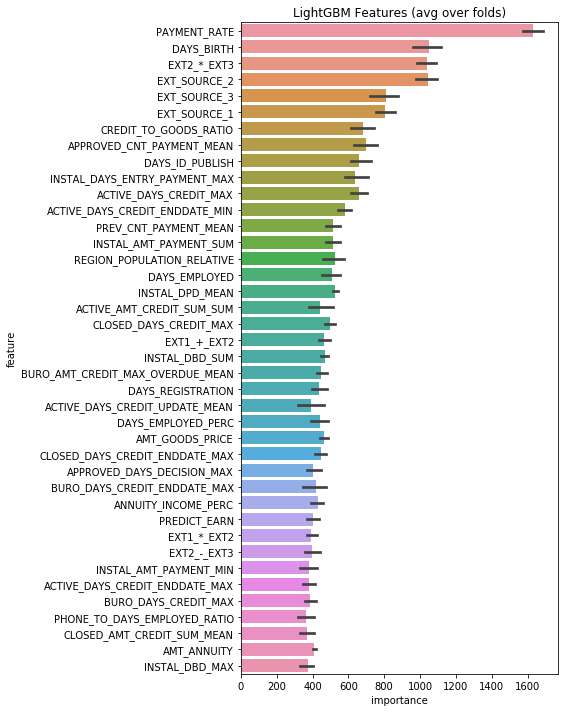

In [0]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= True, debug= debug)

if __name__ == "__main__":
    submission_file_name = "submission_kernel00.csv"
    with timer("Full model run"):
        main()